In [1]:
%load_ext autoreload
%autoreload 2

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import CosineAnnealingLR, LinearLR, SequentialLR
from torch.utils.data import Dataset, DataLoader

from torchvision.datasets import CIFAR10
from torchvision.models import resnet18, resnet34, resnet50
import torchvision.transforms as transforms
from torchsummary import summary

import numpy as np
import time
import pickle

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from medmnist import PathMNIST

from eqCLR.eq_resnet import EqResNet18
from evaluation import model_eval, dataset_to_X_y, lin_eval_rep

In [3]:
###################### PARAMS ##############################

BACKBONE = "resnet18"

BATCH_SIZE = 512
N_EPOCHS = 100 # 1000
N_CPU_WORKERS = 16
BASE_LR = 0.03         # important
WEIGHT_DECAY = 5e-4    # important
MOMENTUM = 0.9
PROJECTOR_HIDDEN_SIZE = 1024
PROJECTOR_OUTPUT_SIZE = 128
CROP_LOW_SCALE = 0.2
GRAYSCALE_PROB = 0.1   # important
PRINT_EVERY_EPOCHS = 5

MODEL_FILENAME = f"path_mnist-{BACKBONE}_wo_rotation-{np.random.randint(10000):04}.pt"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
###################### DATA LOADER #########################

pmnist_train = PathMNIST(split='train', download=False, size=28, root='data/pathmnist/', transform=transforms.ToTensor())
pmnist_test = PathMNIST(split='test', download=False, size=28, root='data/pathmnist/', transform=transforms.ToTensor())

print("Data loaded.")

# additional rotation
class RandomRightAngleRotation:
    """Randomly rotate PIL image by 90, 180, or 270 degrees."""
    def __call__(self, x):
        angle = int(torch.randint(1, 4, ()).item()) * 90
        return x.rotate(angle)

transforms_ssl = transforms.Compose(
    [
        transforms.RandomResizedCrop(size=32, scale=(CROP_LOW_SCALE, 1)),
        # RandomRightAngleRotation(), # additional rotation
        transforms.RandomHorizontalFlip(),
        transforms.RandomApply(
            [transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8
        ),
        transforms.RandomGrayscale(p=GRAYSCALE_PROB),
        transforms.ToTensor(), # NB: runtime faster when this line is last
    ]
)

class PairedTransform:
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, x):
        return (self.transform(x), self.transform(x))


paired_ssl_transforms = PairedTransform(transforms_ssl)

pmnist_train_ssl = PathMNIST(split='train', download=False, size=28, root='data/pathmnist/', transform=paired_ssl_transforms)

pmnist_loader_ssl = DataLoader(
    pmnist_train_ssl,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=N_CPU_WORKERS,
    pin_memory=True,
)

###################### NETWORK ARCHITECTURE #########################

class ResNetwithProjector(nn.Module):
    def __init__(self, backbone_network):
        super().__init__()

        self.backbone = backbone_network(weights=None)
        self.backbone_output_dim = self.backbone.fc.in_features
        
        self.backbone.conv1 = nn.Conv2d(
            3, 64, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.backbone.maxpool = nn.Identity()
        self.backbone.fc = nn.Identity()

        self.projector = nn.Sequential(
            nn.Linear(self.backbone_output_dim, PROJECTOR_HIDDEN_SIZE), 
            nn.ReLU(), 
            nn.Linear(PROJECTOR_HIDDEN_SIZE, PROJECTOR_OUTPUT_SIZE),
        )

    def forward(self, x):
        h = self.backbone(x)
        z = self.projector(h)
        return h, z


def infoNCE(features, temperature=0.5):
    x = F.normalize(features)
    cos_xx = x @ x.T / temperature
    cos_xx.fill_diagonal_(float("-inf"))
    
    batch_size = cos_xx.size(0) // 2
    targets = torch.arange(batch_size * 2, dtype=int, device=cos_xx.device)
    targets[:batch_size] += batch_size
    targets[batch_size:] -= batch_size

    return F.cross_entropy(cos_xx, targets)

backbones = {
   "resnet18": resnet18,    # backbone_output_dim = 512
   "resnet34": resnet34,    # backbone_output_dim = 512
   "resnet50": resnet50,    # backbone_output_dim = 2048
}


Data loaded.


# SimCLR

In [18]:
model_resnet18 = ResNetwithProjector(backbones[BACKBONE]).to(device)
model_resnet18_wo_rotation = ResNetwithProjector(backbones[BACKBONE]).to(device)

In [9]:
#summary(model_resnet18, input_size=(3, 28, 28),  device=device.type)

In [10]:
#print(model_resnet18)

In [20]:
model_resnet18.load_state_dict(torch.load('results/model_weights/1146-path_mnist-resnet18.pt', weights_only=True))
model_resnet18_wo_rotation.load_state_dict(torch.load('results/model_weights/7711-path_mnist-resnet18_wo_rotation.pt', weights_only=True))

<All keys matched successfully>

# EqCLR

In [21]:
model_eq = EqResNet18(N=4).to(device)
model_eq_w_rotation = EqResNet18(N=4).to(device)

#summary(model_eq, input_size=(3, 28, 28),  device=device.type)

In [8]:
# print(model_eq)

In [22]:
model_eq.load_state_dict(torch.load('results/model_weights/3957-path_mnist-eqCLR_resnet18_wo_rotation.pt', weights_only=True))
model_eq_w_rotation.load_state_dict(torch.load('results/model_weights/3943-path_mnist-eqCLR_resnet18_with_rotation.pt', weights_only=True))

<All keys matched successfully>

# Evaluation

In [10]:
transforms_classifier = transforms.Compose(
    [
        transforms.RandomResizedCrop(size=32, scale=(CROP_LOW_SCALE, 1)),
        transforms.RandomHorizontalFlip(),
        RandomRightAngleRotation(), # additional rotation
        transforms.ToTensor(),
    ]
)

pmnist_train_classifier = PathMNIST(split='train', download=False, size=28, root='data/pathmnist/', transform=transforms_classifier)


pmnist_loader_classifier = DataLoader(
    pmnist_train_classifier,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=N_CPU_WORKERS,
)

In [11]:
eval_dict_resnet18 = model_eval(model_resnet18, pmnist_train, pmnist_test, pmnist_loader_classifier, n_classes=9)

------------------ KNN Evaluation ------------------
---------- KNN with euclidean distance ----------
KNN (k=1, metric=euclidean): 83.01%
KNN (k=5, metric=euclidean): 84.60%
KNN (k=10, metric=euclidean): 85.32%
---------- KNN with cosine distance ----------
KNN (k=1, metric=cosine): 82.91%
KNN (k=5, metric=cosine): 84.33%
KNN (k=10, metric=cosine): 84.83%
------------------ Logistic Regression ------------------
Logistic Regression: 86.80%


/gpfs01/berens/user/nkury/miniconda3/envs/eq_env2/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Linear accuracy (sklearn): 0.8558495821727019
------------------ Linear Evaluation with precomputed representations ------------------
Linear accuracy (Adam on precomputed representations): 0.851949860724234
------------------ Linear Evaluation with augmentations ------------------
Epoch 5, average loss 0.1412, 12.2 s
Epoch 10, average loss 0.1351, 11.6 s
Epoch 15, average loss 0.1290, 11.6 s
Epoch 20, average loss 0.1264, 11.3 s
Epoch 25, average loss 0.1245, 12.0 s
Epoch 30, average loss 0.1232, 11.3 s
Epoch 35, average loss 0.1226, 11.6 s
Epoch 40, average loss 0.1233, 11.2 s
Epoch 45, average loss 0.1211, 12.5 s
Epoch 50, average loss 0.1205, 13.0 s
Epoch 55, average loss 0.1198, 11.4 s
Epoch 60, average loss 0.1207, 11.4 s
Epoch 65, average loss 0.1198, 11.5 s
Epoch 70, average loss 0.1197, 12.9 s
Epoch 75, average loss 0.1190, 11.5 s
Epoch 80, average loss 0.1192, 11.3 s
Epoch 85, average loss 0.1192, 12.1 s
Epoch 90, average loss 0.1183, 11.6 s
Epoch 95, average loss 0.1187, 12.

In [13]:
# SimCLR
with open('results/model_eval/eval_dict_SimCLR_pathmnist.pkl', 'rb') as f:
    eval_dict_resnet18 = pickle.load(f)

# SimCLR  without rotation
with open('results/model_eval/eval_dict_SimCLR_wo_rotation_pathmnist.pkl', 'rb') as f:
    eval_dict_resnet18_wo_rotation = pickle.load(f)

# EqCLR
with open('results/model_eval/eval_dict_eqCLR_pathmnist.pkl', 'rb') as f:
    eval_dict_eq = pickle.load(f)

# EqCLR
with open('results/model_eval/eval_dict_eqCLR_w_rotation_pathmnist.pkl', 'rb') as f:
    eval_dict_eq_w_rotation = pickle.load(f)


In [17]:
import pandas as pd

models = {
    "eqResnet18": eval_dict_eq,
    "eqResnet18_w_rotation": eval_dict_eq_w_rotation,
    "Resnet18": eval_dict_resnet18,
    "Resnet18_wo_rotation": eval_dict_resnet18_wo_rotation,
    }

eval_dict_all = {}

for model in models:
    eval_dict_all[model] = {}
    eval_dict = models[model]
    eval_dict_all[model]['KNN (k=10, euclidean)'] = eval_dict['euclidean'][10]
    eval_dict_all[model]['KNN (k=10, cosine)'] = eval_dict['cosine'][10]

    for key in eval_dict:
        if key != "cosine" and key != "euclidean" and key != 'linear_accuracy':
            eval_dict_all[model][key] = eval_dict[key]
    


evals_df = pd.DataFrame(eval_dict_all).T

display(evals_df)

,"KNN (k=10, euclidean)","KNN (k=10, cosine)",logistic_regression,linear_accuracy_rep,linear_accuracy_aug
eqResnet18,0.832033,0.833844,0.834262,0.833844,0.803621
eqResnet18_w_rotation,0.819916,0.817688,0.832173,0.834123,0.793036
Resnet18,0.853203,0.848329,0.867967,0.863370,0.826323
Resnet18_wo_rotation,0.857521,0.854318,0.862813,0.864763,0.847354


# Rotation invariance

In [34]:
import matplotlib.pyplot as plt
import random

TypeError: Invalid shape (3, 28, 28) for image data

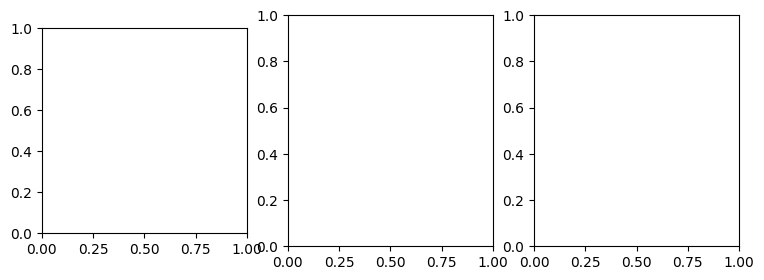

In [44]:
rand_idx = [random.randint(0, len(pmnist_test)-1) for _ in range(3)]
X_samples = [pmnist_test[i][0].cpu().numpy() for i in rand_idx]
y_samples = [pmnist_test[i][1] for i in rand_idx]

fig, axes = plt.subplots(1, 3, figsize=(9, 3))

for i in range(3):
    img, label = X_samples[i], y_samples[i]
    axes[i].imshow(img)  # show as grayscale
    axes[i].set_title(f"Label: {label}")
    axes[i].axis('off')


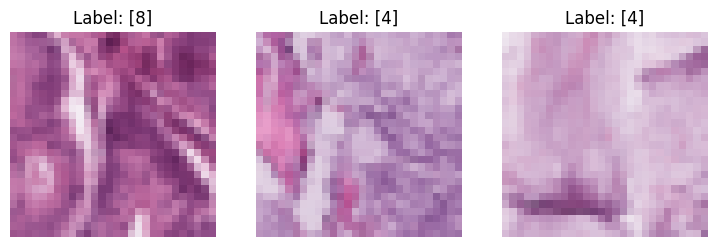

In [56]:
import random
import matplotlib.pyplot as plt

rand_idx = [random.randint(0, len(pmnist_test)-1) for _ in range(3)]
rand_idx = [0,1,2]
X_samples = [pmnist_test[i][0].cpu().numpy() for i in rand_idx]
y_samples = [pmnist_test[i][1] for i in rand_idx]

fig, axes = plt.subplots(1, 3, figsize=(9, 3))

for i in range(3):
    img, label = X_samples[i], y_samples[i]

    img_rgb = img.transpose(1, 2, 0)  
    axes[i].imshow(img_rgb)
    
    axes[i].set_title(f"Label: {label}")
    axes[i].axis('off')

plt.show()


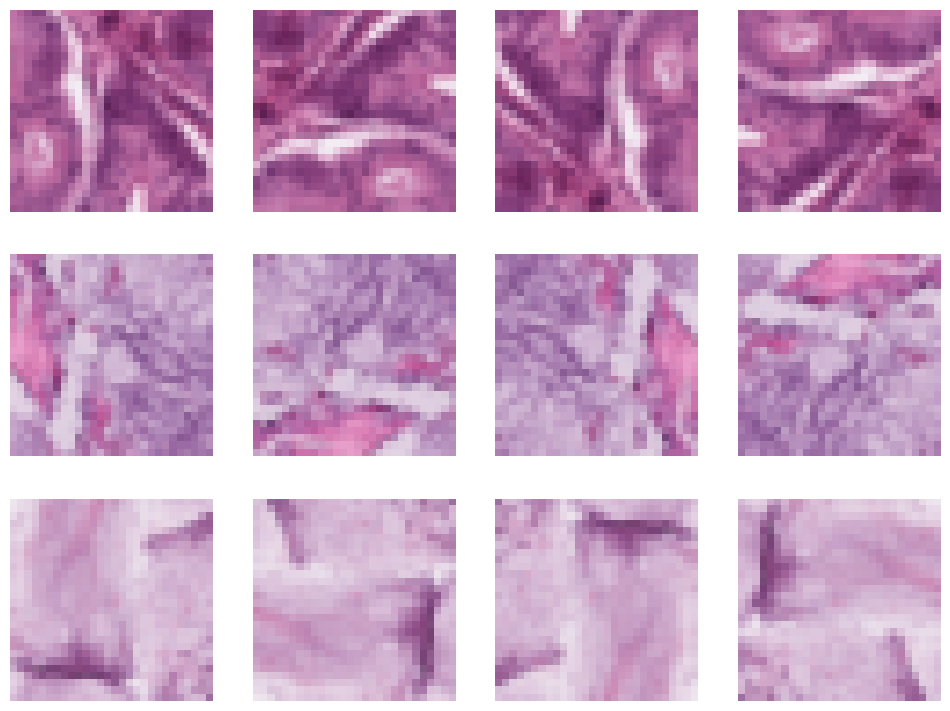

In [57]:
fig, axes = plt.subplots(3, 4, figsize=(12, 9))

rotated_samples = {}  # store all rotations

for i, img in enumerate(X_samples):
    rotated_samples[i] = {}  # list to store all rotations
    for k in range(4):
        # rotate along H and W axes (axes 1 and 2)
        rot_img = np.rot90(img, k, axes=(1, 2))
        # transpose to HWC for imshow
        rot_img_HWC = rot_img.transpose(1, 2, 0)
        rotated_samples[i] = rot_img_HWC
        
        axes[i, k].imshow(rot_img_HWC)  # show the transposed image
        axes[i, k].axis('off')



In [24]:
# SimCLR
with torch.no_grad():
    X_train, y_train, Z_train = dataset_to_X_y(pmnist_train, model_resnet18)
    X_test, y_test, Z_test = dataset_to_X_y(pmnist_test, model_resnet18)

acc_simclr, classifier_simclr = lin_eval_rep(X_train, y_train, X_test, y_test, n_epochs=500, return_model=True)

Linear accuracy (Adam on precomputed representations): 0.851949860724234
